In [ ]:
#Inspired by https://imgur.com/6sPyczX
#Replicated image then extended to other years, colored by playoffs
#Added line of best fit
#Checked Pearson's Correlation Coefficient
#Will plot all years together

In [163]:
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
import urllib3

In [87]:
def get_response(url):
    print(f"Requesting \'{url}\'")
    try:
        r = requests.get(url)
        text = r.text
        text= text.replace("<!--", "")
        text= text.replace("-->", "")
        return BeautifulSoup(text, 'lxml')
    except requests.exceptions.RequestException as e:
        print(e)
    return None

In [132]:
teams = {'Atlanta Hawks':'ATL',
'Boston Celtics':'BOS',
'Brooklyn Nets':'BRK',
'Charlotte Bobcats':'CHA',
'Charlotte Hornets':'CHO',
'Chicago Bulls':'CHI',
'Cleveland Cavaliers':'CLE',
'Dallas Mavericks':'DAL',
'Denver Nuggets':'DEN',
'Detroit Pistons':'DET',
'Golden State Warriors':'GSW',
'Houston Rockets':'HOU',
'Indiana Pacers':'IND',
'Los Angeles Clippers':'LAC',
'Los Angeles Lakers':'LAL',
'Memphis Grizzlies':'MEM',
'Miami Heat':'MIA',
'Milwaukee Bucks':'MIL',
'Minnesota Timberwolves':'MIN',
'New Jersey Nets':'NJN',
'New Orleans Hornets':'NOH',
'New Orleans Pelicans':'NOP',
'New OrleansOklahoma City Hornets':'NOK',
'New York Knicks':'NYK',
'Oklahoma City Thunder':'OKC',
'Orlando Magic':'ORL',
'Philadelphia 76ers':'PHI',
'Phoenix Suns':'PHO',
'Portland Trail Blazers':'POR',
'Sacramento Kings':'SAC',
'San Antonio Spurs':'SAS',
'Seattle SuperSonics':'SEA',
'Toronto Raptors':'TOR',
'Utah Jazz':'UTA',
'Vancouver Grizzlies':'VAN',
'Washington Bullets':'WSB',
'Washington Wizards':'WAS'}


In [216]:
#for year in range(1988,2020):
def get_ages(year):
    team_col=[]
    age_mp_col=[]
    for team in teams:
        data = []
        url = f"https://www.basketball-reference.com/teams/{teams[team]}/{year}.html"
        soup = get_response(url)
        table = soup.find('table', attrs={'id':"totals"})
        if table == None:
            print(teams[team],"not in ",year)
            continue
        table_head = table.find('thead')
        hrow = table_head.find('tr')
        hcols = hrow.find_all('th')
        hcols = [ele.text.strip() for ele in hcols]
        data.append([ele for ele in hcols if ele])
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            cols = [ele.text.strip() for ele in row.find_all('th')]
            if cols[0] == 'Rk':
                continue
            cols += [ele.text.strip() for ele in row.find_all('td')]
            data.append([ele for ele in cols])    
        df=pd.DataFrame(data)
        col=df.iloc[0][:-1]
        df=df.set_index(0)
        df.columns = col
        df=df.drop("Rk").rename(columns={"Rk":"player"}).set_index("player")
        df["Age"]=df["Age"].astype(int)
        df["MP"]=df["MP"].astype(int)
        df["AgeMP"]=df['Age']*df["MP"]
        age_mp_col.append(sum(df["AgeMP"])/sum(df["MP"]))
        team_col.append(teams[team])
    age_df = pd.DataFrame([team_col, age_mp_col]).T
    age_df.columns = ["Tm","ages"]

    pd.set_option('precision', 3)
    directory = os.path.join(os.getcwd(),'scrapedata')
    east, west = pd.DataFrame(), pd.DataFrame()
    for filename in os.listdir(directory):
        if re.match(f"[a-z]+s_standings_E_{year}.csv", filename): #Scraped with "second_player_stats_scrape.ipynb"
            east = pd.read_csv(os.path.join(directory,filename))
        elif re.match(f"[a-z]+s_standings_W_{year}.csv", filename):
            west = pd.read_csv(os.path.join(directory,filename))

    east = east.rename(columns = {'Eastern Conference':'Tm'}).sort_values('W/L%', ascending=False).reset_index(drop=True)
    west = west.rename(columns = {'Western Conference':'Tm'}).sort_values('W/L%', ascending=False).reset_index(drop=True)
    standings = pd.concat([east, west]).dropna()
    standings = standings.loc[:,['Tm','W','L','W/L%']]
    standings['playoffs'] = standings['Tm'].str.contains('\*').astype(int)
    standings['seed'] = standings.index + 1
    if year == 2019:
        standings['playoffs'][standings.index < 8] = 1   # assume playoffs for top 8 teams in each conference
    standings['games'] = standings['W'] + standings ['L']
    standings['Tm'] = standings['Tm'].str.replace('[^\w\s]+','').str.replace('\d+\s*$','').str.strip()
    standings = standings.replace({'Tm':teams}, regex=True)
    if year < 2003:   # if year is < 2003 replace CHA with CHH. ugly but it works!
        standings['Tm'].replace('CHO','CHH', inplace=True)
    standings = standings.drop(['W','L'], axis=1)

    df_merge = pd.merge(age_df, standings, on='Tm', how='left')
    df_merge['ages'] = df_merge['ages'].astype(float)
    df_merge['W/L%'] = df_merge['W/L%'].astype(float)
    return df_merge
#get_ages(2019)


In [217]:
def plot_ages(year):
    df_merge=get_ages(year)
    print ("Correlation coefficient:",np.corrcoef(list(df_merge["ages"]), list(df_merge["W/L%"]))[0,1])
    plt.scatter(df_merge["ages"],df_merge["W/L%"],c=df_merge["playoffs"])
    for i in range(len(df_merge)):
        plt.annotate(df_merge["Tm"][i],(df_merge["ages"][i],df_merge["W/L%"][i]),xytext=(df_merge["ages"][i]+.05,df_merge["W/L%"][i]+.01))
    plt.plot(np.unique(df_merge["ages"]), np.poly1d(np.polyfit(df_merge["ages"], df_merge["W/L%"], 1))(np.unique(df_merge["ages"])))
    plt.xlabel("Age")
    plt.ylabel("W/L %")
    plt.title("Age vs W/L% in "+str(year))
    plt.show()

Requesting 'https://www.basketball-reference.com/teams/ATL/2000.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2000.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2000.html'
BRK not in  2000
Requesting 'https://www.basketball-reference.com/teams/CHA/2000.html'
CHA not in  2000
Requesting 'https://www.basketball-reference.com/teams/CHO/2000.html'
CHO not in  2000
Requesting 'https://www.basketball-reference.com/teams/CHI/2000.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2000.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2000.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2000.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2000.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2000.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2000.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2000.html'
Requesting 'https://www.basketball-refe

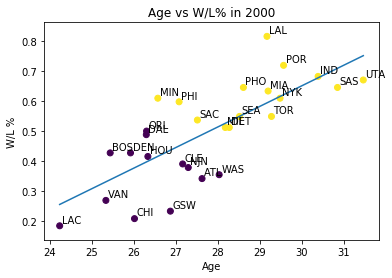

Requesting 'https://www.basketball-reference.com/teams/ATL/2001.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2001.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2001.html'
BRK not in  2001
Requesting 'https://www.basketball-reference.com/teams/CHA/2001.html'
CHA not in  2001
Requesting 'https://www.basketball-reference.com/teams/CHO/2001.html'
CHO not in  2001
Requesting 'https://www.basketball-reference.com/teams/CHI/2001.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2001.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2001.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2001.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2001.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2001.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2001.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2001.html'
Requesting 'https://www.basketball-refe

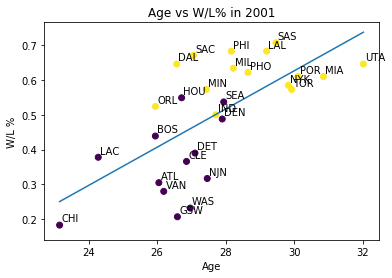

Requesting 'https://www.basketball-reference.com/teams/ATL/2002.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2002.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2002.html'
BRK not in  2002
Requesting 'https://www.basketball-reference.com/teams/CHA/2002.html'
CHA not in  2002
Requesting 'https://www.basketball-reference.com/teams/CHO/2002.html'
CHO not in  2002
Requesting 'https://www.basketball-reference.com/teams/CHI/2002.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2002.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2002.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2002.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2002.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2002.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2002.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2002.html'
Requesting 'https://www.basketball-refe

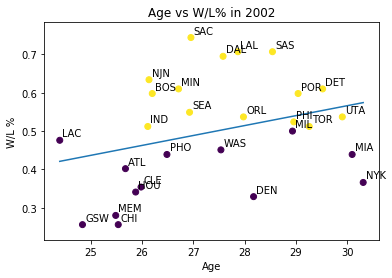

Requesting 'https://www.basketball-reference.com/teams/ATL/2003.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2003.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2003.html'
BRK not in  2003
Requesting 'https://www.basketball-reference.com/teams/CHA/2003.html'
CHA not in  2003
Requesting 'https://www.basketball-reference.com/teams/CHO/2003.html'
CHO not in  2003
Requesting 'https://www.basketball-reference.com/teams/CHI/2003.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2003.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2003.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2003.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2003.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2003.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2003.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2003.html'
Requesting 'https://www.basketball-refe

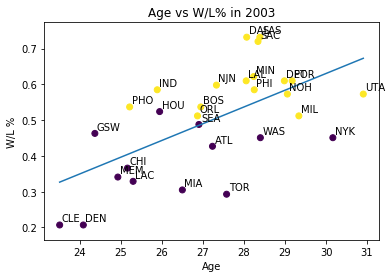

Requesting 'https://www.basketball-reference.com/teams/ATL/2004.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2004.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2004.html'
BRK not in  2004
Requesting 'https://www.basketball-reference.com/teams/CHA/2004.html'
CHA not in  2004
Requesting 'https://www.basketball-reference.com/teams/CHO/2004.html'
CHO not in  2004
Requesting 'https://www.basketball-reference.com/teams/CHI/2004.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2004.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2004.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2004.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2004.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2004.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2004.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2004.html'
Requesting 'https://www.basketball-refe

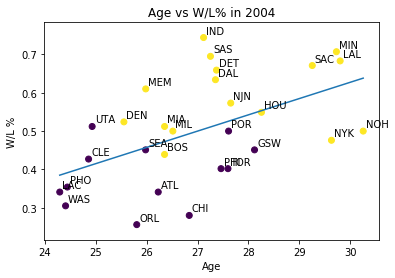

Requesting 'https://www.basketball-reference.com/teams/ATL/2005.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2005.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2005.html'
BRK not in  2005
Requesting 'https://www.basketball-reference.com/teams/CHA/2005.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2005.html'
CHO not in  2005
Requesting 'https://www.basketball-reference.com/teams/CHI/2005.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2005.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2005.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2005.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2005.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2005.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2005.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2005.html'
Requesting 'https://www.basketball-reference.com/teams/L

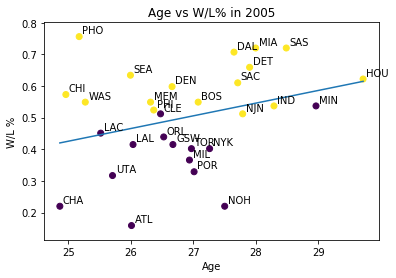

Requesting 'https://www.basketball-reference.com/teams/ATL/2006.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2006.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2006.html'
BRK not in  2006
Requesting 'https://www.basketball-reference.com/teams/CHA/2006.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2006.html'
CHO not in  2006
Requesting 'https://www.basketball-reference.com/teams/CHI/2006.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2006.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2006.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2006.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2006.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2006.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2006.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2006.html'
Requesting 'https://www.basketball-reference.com/teams/L

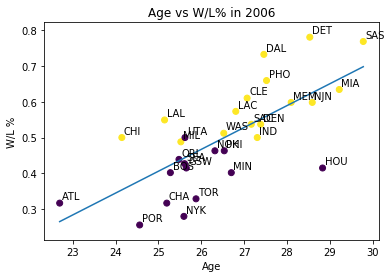

Requesting 'https://www.basketball-reference.com/teams/ATL/2007.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2007.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2007.html'
BRK not in  2007
Requesting 'https://www.basketball-reference.com/teams/CHA/2007.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2007.html'
CHO not in  2007
Requesting 'https://www.basketball-reference.com/teams/CHI/2007.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2007.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2007.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2007.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2007.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2007.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2007.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2007.html'
Requesting 'https://www.basketball-reference.com/teams/L

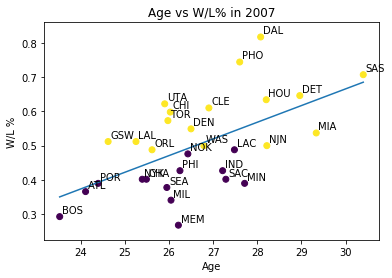

Requesting 'https://www.basketball-reference.com/teams/ATL/2008.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2008.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2008.html'
BRK not in  2008
Requesting 'https://www.basketball-reference.com/teams/CHA/2008.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2008.html'
CHO not in  2008
Requesting 'https://www.basketball-reference.com/teams/CHI/2008.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2008.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2008.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2008.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2008.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2008.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2008.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2008.html'
Requesting 'https://www.basketball-reference.com/teams/L

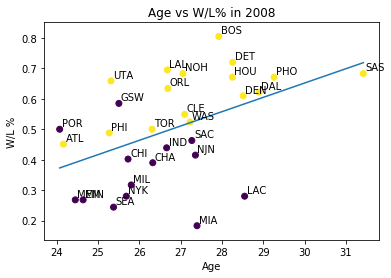

Requesting 'https://www.basketball-reference.com/teams/ATL/2009.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2009.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2009.html'
BRK not in  2009
Requesting 'https://www.basketball-reference.com/teams/CHA/2009.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2009.html'
CHO not in  2009
Requesting 'https://www.basketball-reference.com/teams/CHI/2009.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2009.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2009.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2009.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2009.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2009.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2009.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2009.html'
Requesting 'https://www.basketball-reference.com/teams/L

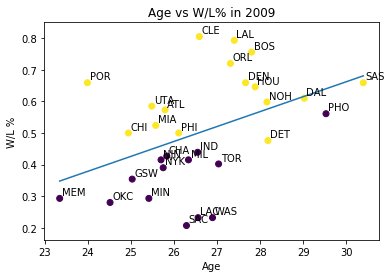

Requesting 'https://www.basketball-reference.com/teams/ATL/2010.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2010.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2010.html'
BRK not in  2010
Requesting 'https://www.basketball-reference.com/teams/CHA/2010.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2010.html'
CHO not in  2010
Requesting 'https://www.basketball-reference.com/teams/CHI/2010.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2010.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2010.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2010.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2010.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2010.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2010.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2010.html'
Requesting 'https://www.basketball-reference.com/teams/L

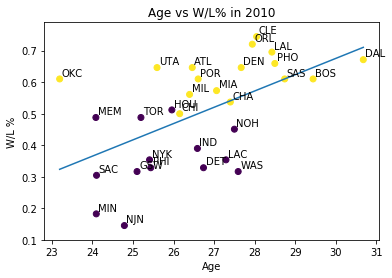

Requesting 'https://www.basketball-reference.com/teams/ATL/2011.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2011.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2011.html'
BRK not in  2011
Requesting 'https://www.basketball-reference.com/teams/CHA/2011.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2011.html'
CHO not in  2011
Requesting 'https://www.basketball-reference.com/teams/CHI/2011.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2011.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2011.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2011.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2011.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2011.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2011.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2011.html'
Requesting 'https://www.basketball-reference.com/teams/L

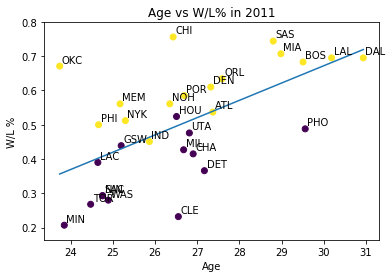

Requesting 'https://www.basketball-reference.com/teams/ATL/2012.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2012.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2012.html'
BRK not in  2012
Requesting 'https://www.basketball-reference.com/teams/CHA/2012.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2012.html'
CHO not in  2012
Requesting 'https://www.basketball-reference.com/teams/CHI/2012.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2012.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2012.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2012.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2012.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2012.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2012.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2012.html'
Requesting 'https://www.basketball-reference.com/teams/L

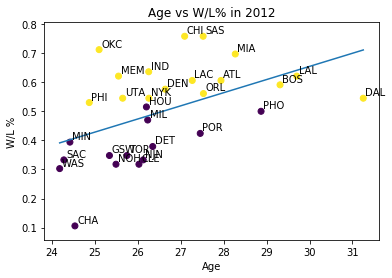

Requesting 'https://www.basketball-reference.com/teams/ATL/2013.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2013.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2013.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2013.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2013.html'
CHO not in  2013
Requesting 'https://www.basketball-reference.com/teams/CHI/2013.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2013.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2013.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2013.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2013.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2013.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2013.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2013.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2013.html'
Req

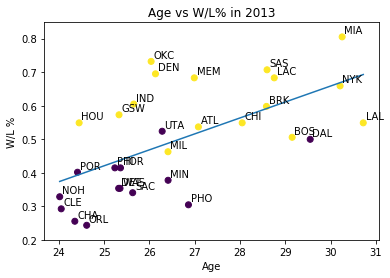

Requesting 'https://www.basketball-reference.com/teams/ATL/2014.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2014.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2014.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2014.html'
Requesting 'https://www.basketball-reference.com/teams/CHO/2014.html'
CHO not in  2014
Requesting 'https://www.basketball-reference.com/teams/CHI/2014.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2014.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2014.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2014.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2014.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2014.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2014.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2014.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2014.html'
Req

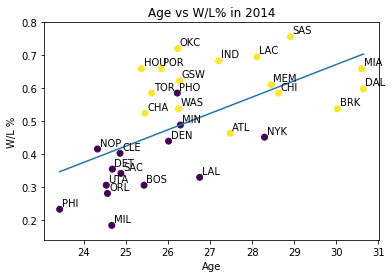

Requesting 'https://www.basketball-reference.com/teams/ATL/2015.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2015.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2015.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2015.html'
CHA not in  2015
Requesting 'https://www.basketball-reference.com/teams/CHO/2015.html'
Requesting 'https://www.basketball-reference.com/teams/CHI/2015.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2015.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2015.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2015.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2015.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2015.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2015.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2015.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2015.html'
Req

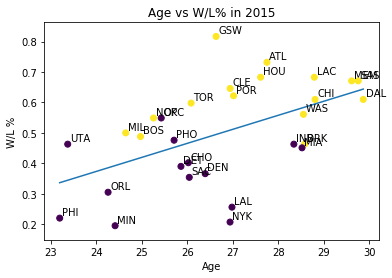

Requesting 'https://www.basketball-reference.com/teams/ATL/2016.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2016.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2016.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2016.html'
CHA not in  2016
Requesting 'https://www.basketball-reference.com/teams/CHO/2016.html'
Requesting 'https://www.basketball-reference.com/teams/CHI/2016.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2016.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2016.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2016.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2016.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2016.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2016.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2016.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2016.html'
Req

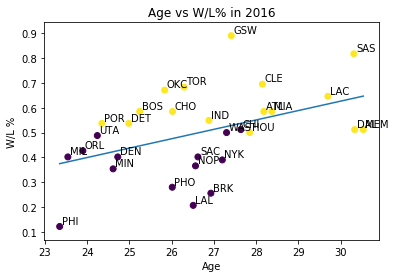

Requesting 'https://www.basketball-reference.com/teams/ATL/2017.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2017.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2017.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2017.html'
CHA not in  2017
Requesting 'https://www.basketball-reference.com/teams/CHO/2017.html'
Requesting 'https://www.basketball-reference.com/teams/CHI/2017.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2017.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2017.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2017.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2017.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2017.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2017.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2017.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2017.html'
Req

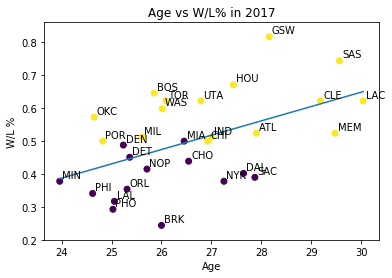

Requesting 'https://www.basketball-reference.com/teams/ATL/2018.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2018.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2018.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2018.html'
CHA not in  2018
Requesting 'https://www.basketball-reference.com/teams/CHO/2018.html'
Requesting 'https://www.basketball-reference.com/teams/CHI/2018.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2018.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2018.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2018.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2018.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2018.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2018.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2018.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2018.html'
Req

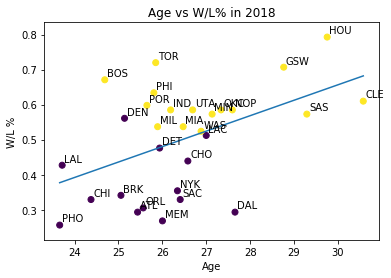

Requesting 'https://www.basketball-reference.com/teams/ATL/2019.html'
Requesting 'https://www.basketball-reference.com/teams/BOS/2019.html'
Requesting 'https://www.basketball-reference.com/teams/BRK/2019.html'
Requesting 'https://www.basketball-reference.com/teams/CHA/2019.html'
CHA not in  2019
Requesting 'https://www.basketball-reference.com/teams/CHO/2019.html'
Requesting 'https://www.basketball-reference.com/teams/CHI/2019.html'
Requesting 'https://www.basketball-reference.com/teams/CLE/2019.html'
Requesting 'https://www.basketball-reference.com/teams/DAL/2019.html'
Requesting 'https://www.basketball-reference.com/teams/DEN/2019.html'
Requesting 'https://www.basketball-reference.com/teams/DET/2019.html'
Requesting 'https://www.basketball-reference.com/teams/GSW/2019.html'
Requesting 'https://www.basketball-reference.com/teams/HOU/2019.html'
Requesting 'https://www.basketball-reference.com/teams/IND/2019.html'
Requesting 'https://www.basketball-reference.com/teams/LAC/2019.html'
Req

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


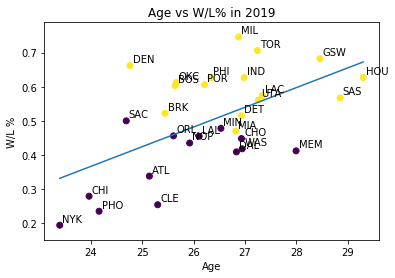

In [218]:
for year in range(2000,2020):
    plot_ages(year)